In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
Threads.nthreads()

1

In [4]:
using LoopVectorization
using Tables
using Test
using Plots
using ThreadTools

In [5]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [6]:
include("../src/parallel_helpers.jl");

In [7]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

In [ ]:
lods_from_gemma = CSV.File("output/lods_from_gemma.csv", header = false) |> Tables.matrix;

In [8]:
pheno_108 = reshape(pheno[:, 108], :, 1);
(y0_108, X0, lambda0) = transform_rotation(pheno_108, geno, kinship_Gc);
X0_intercept = reshape(X0[:, 1], :, 1);
X0_covar = X0[:, 2:end];

## Get alt_assumption results w/o prior:

In [11]:
results_scan_alt = scan_alt(pheno_108, geno, kinship_Gc; reml = false);
hsqs_from_alt = results_scan_alt[3];
lods_from_alt = results_scan_alt[4];

In [73]:
hsq_from_null = results_scan_alt[2]; # fitted h2 with just the (rotated) intercept (null model)
sigma2_from_null = results_scan_alt[1]; # fitted sigma2 with just the (rotated) intercept (null model)

In [74]:
var(pheno_108)

1.6944289276209026

In [143]:
w_0_noBayes = makeweights(hsq_from_null, lambda0);

In [136]:
w_229_noBayes = makeweights(hsqs_from_alt[229], lambda0);

In [144]:
y00_108_noBayes = rowMultiply(y0_108, sqrt.(w_0_noBayes));
X00_noBayes = rowMultiply(X0, sqrt.(w_0_noBayes));

In [145]:
var(y00_108_noBayes)

2.42140129672865e9

In [146]:
hsq_from_null

0.999999984947842

In [147]:
sigma2_from_null

2.295618788926793

In [148]:
1-sigma2_from_null/var(y00_108_noBayes)

0.9999999990519461

Any unusual LODs (less than 0) ?

In [13]:
# LODs from scan_alt()
findall(lods_from_alt .< 0)

245-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

## Get alt_assumption results w/ prior:

### functions

In [706]:
hcat(makeweights(0.99, lambda0), makeweights_delta(0.99, lambda0))

79×2 Matrix{Float64}:
 1.0         1.0
 0.192965    0.192965
 0.107249    0.107249
 0.0936438   0.0936438
 0.0615791   0.0615791
 0.0535278   0.0535278
 0.051644    0.051644
 0.0475213   0.0475213
 0.0450099   0.0450099
 0.043622    0.043622
 0.0419871   0.0419871
 0.039784    0.039784
 0.0387993   0.0387993
 ⋮           
 0.00519658  0.00519658
 0.00499658  0.00499658
 0.00475156  0.00475156
 0.00467243  0.00467243
 0.00451079  0.00451079
 0.00382809  0.00382809
 0.00368365  0.00368365
 0.00357798  0.00357798
 0.00353566  0.00353566
 0.00328263  0.00328263
 0.00294727  0.00294727
 0.00237859  0.00237859

In [1445]:
function makeweights(h2::Float64, lambda::Array{Float64,1})

    vars = h2*lambda .+ (1.0-h2)
    return 1.0./vars

end

makeweights (generic function with 1 method)

In [915]:
function makeweights_delta(h2::Float64, lambda::Array{Float64,1})

    delta = h2/(1-h2);
    vars = (delta.*lambda .+ 1);
    return 1.0./vars

end

makeweights_delta (generic function with 1 method)

In [916]:
function wls(y::Array{Float64, 2}, X::Array{Float64, 2}, w::Array{Float64, 1}, 
                   prior::Array{Float64, 1};
                   reml::Bool = false, loglik::Bool = true, method = "qr")

    (n, p) = size(X); # get number of observations and the number of markers from geno dimensions      

    n = size(y, 1); # get number of observations       

    # check if weights are positive
    if(any(w .<= .0))
        error("Some weights are not positive.")
    end

    # square root of the weights
    sqrtw = sqrt.(w)

    # logdetXtX = logdet(X' * X); constant term that does not depend on the parameters (weights); is not needed

    # scale by weights
    yy = rowMultiply(y, sqrtw)
    XX = rowMultiply(X, sqrtw)

    # least squares solution
    # faster but numerically less stable
    if(method == "cholesky")
        fct = cholesky(XX'XX)
        b = fct\(XX'yy)
        logdetXXtXX = logdet(fct)
    end

    # slower but numerically more stable
    if(method == "qr")
        fct = qr(XX)
        b = fct\yy
        logdetXXtXX = 2*logabsdet(fct.R)[1];

    end

    yyhat = XX*b
    rss0 = sum((yy-yyhat).^2)

    if(reml)
        sigma2 = rss0/(n-p)
    else
        sigma2 = (rss0+prior[1]*prior[2])/(n+prior[2])
    end

    # see formulas (2) and (3) of Kang (2008)
    if(loglik)

        # ell = -0.5 * (n*log(sigma2) - sum(log.(w)) + rss0/sigma2)
        ell = -0.5 * ((n+prior[2])*log(sigma2) - sum(log.(w)) + (rss0+prior[1]*prior[2])/sigma2)

        if(reml)
            # ell = ell + 0.5 * (p*log(2pi*sigma2) + logdetXtX - logdetXXtXX) # full log-likelihood including the constant terms;
            ell = ell + 0.5 * (p*log(sigma2) - logdetXXtXX)
        end
        
    else
        ell = missing;
    end

    return LSEstimates(b, sigma2, ell)

end

wls (generic function with 2 methods)

In [1359]:
function fitlmm(y::Array{Float64, 2}, X::Array{Float64, 2}, lambda::Array{Float64, 1}, 
                    prior::Array{Float64, 1};
                    reml::Bool = false, method::String = "qr", loglik::Bool = true, 
                    h20::Float64 = 0.5, d::Float64 = 1.0)
    
    function logLik0(h2::Float64)
        # out = wls(y, X, makeweights_delta(h2, lambda), prior; 
        #          reml = reml, loglik = loglik, method = method)
        
        out = wls(y, X, makeweights_delta(h2, lambda), prior; 
                 reml = reml, loglik = loglik, method = method)
        return -out.ell
    end
    
    ## avoid the use of global variable in inner function;

    opt = optimize(logLik0, max(h20-d, 0.0), min(h20+d, 1.0))
    h2 = opt.minimizer
    # est = wls(y, X, makeweights_delta(h2, lambda), prior; reml = reml, loglik = loglik, method = method)
    est = wls(y, X, makeweights_delta(h2, lambda), prior; reml = reml, loglik = loglik, method = method)
    return LMMEstimates(est.b, est.sigma2, h2, est.ell)
end

fitlmm (generic function with 3 methods)

In [1121]:
test = fitlmm(y0_108, hcat(X0_intercept, X0_covar[:, 229]), lambda0, prior)

LMMEstimates([6.378529983988148; -0.6925971729917539;;], 1.788534845458891, 0.8129896939872916, -60.278604069870745)

In [1125]:
test.h2 # optimized by Brent's method

0.8129896939872916

In [1126]:
test.ell # maximized LL

-60.278604069870745

In [1128]:
test_h2_099 = wls(y0_108, hcat(X0_intercept, X0_covar[:, 229]), makeweights(0.99, lambda0), prior; reml = false);

In [1130]:
test_h2_099_null = wls(y0_108, X0_intercept, makeweights(0.99, lambda0), prior; reml = false);

In [1129]:
test_h2_099.ell

-59.9800806925836

In [1131]:
test_h2_099_null.ell

-61.78414571381346

In [1085]:
function scan_alt(y::Array{Float64, 2}, g::Array{Float64, 2}, K::Array{Float64, 2}, 
                  prior::Array{Float64, 1}; 
                  reml::Bool = false)

    # number of markers
    (n, p) = size(g)
    # make intercept
    intercept = ones(n, 1)
    # rotate data
    (y0, X0, lambda0) = rotateData(y, [intercept g], K)

    pve_list = Array{Float64, 1}(undef, p);

    X00 = reshape(X0[:, 1], :, 1)
    # fit null lmm
    out00 = fitlmm(y0, X00, lambda0, prior; reml = reml);

    lod = zeros(p)
    X = zeros(n, 2)
    X[:, 1] = X0[:, 1]
    for i = 1:p
        X[:, 2] = X0[:, i+1]
        
        out11 = fitlmm(y0, X, lambda0, prior; reml = reml);

        pve_list[i] = out11.h2;

        lod[i] = (out11.ell - out00.ell)/log(10)
    end

    return (out00.sigma2, out00.h2, pve_list, lod)

end

scan_alt (generic function with 2 methods)

### results

In [1086]:
# prior = [sum((y0_108 .- mean(y0_108)).^2), 1/100];

In [1087]:
prior

2-element Vector{Float64}:
  1.6944289276209026
 10.0

In [1088]:
y00_108_test = rowMultiply(y0_108, sqrt.(makeweights(0.0, lambda0)));

In [1089]:
var(y0_108)

38.062170489777195

In [1090]:
var(y00_108_test)

38.062170489777195

In [984]:
prior = [var(y00_108_test), 1/100];

In [1091]:
results_scan_alt_b = scan_alt(pheno_108, geno, kinship_Gc, prior; reml = false);
hsqs_from_alt_b = results_scan_alt_b[3];
lods_from_alt_b = results_scan_alt_b[4];

In [1092]:
hsq_from_null_b = results_scan_alt_b[2]; # fitted h2 with just the (rotated) intercept (null model)
sigma2_from_null_b = results_scan_alt_b[1]; # fitted sigma2 with just the (rotated) intercept (null model)

In [1093]:
hsq_from_null_b

0.999999984947842

In [1097]:
w_0_Bayes = makeweights_delta(hsq_from_null_b, lambda0);

In [1098]:
w_229_Bayes = makeweights_delta(hsqs_from_alt_b[229], lambda0);

In [1099]:
y00_108_Bayes = rowMultiply(y0_108, sqrt.(w_0_Bayes));
X00_Bayes = rowMultiply(X0, sqrt.(w_0_Bayes));

In [1100]:
var(y00_108_Bayes)

36.44731481378111

In [1101]:
hsq_from_null_b

0.999999984947842

In [1102]:
sigma2_from_null_b

2.2280693663081537

In [1103]:
1-sigma2_from_null_b/var(y00_108_Bayes)

0.9388687650189885

In [1104]:
hcat(lods_from_alt, lods_from_alt_b, lods_from_gemma[:, 108])

7321×3 Matrix{Float64}:
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.0219153   0.0225785  0.0219155
 0.021912    0.0225751  0.0219122
 0.0567256   0.0584371  0.0567251
 ⋮                      
 0.248678    0.256058   0.248678
 0.248678    0.256058   0.248678
 0.248678    0.256058   0.248678
 0.0686881  -0.0146636  0.0686887
 0.124881    0.128627   0.124882
 0.124881    0.128627   0.124882
 0.249213    0.256608   0.249213
 0.273645    0.281748   0.273645
 0.271594    0.279638   0.271594
 0.285893    0.294349   0.285893
 0.229505    0.236327   0.229504
 0.229505    0.236327   0.229504

Let's look at how the negative LODs are corrected in this manner, with comparisons with GEMMA LODs...

In [1105]:
vcat(["uncorrected" "corrected" "gemma"],
    hcat(lods_from_alt[findall(lods_from_alt .< 0)], 
         lods_from_alt_b[findall(lods_from_alt .< 0)], 
         lods_from_gemma[:, 108][lods_from_alt .< 0]))

246×3 Matrix{Any}:
   "uncorrected"    "corrected"   "gemma"
 -2.2873          -2.20946       0.736546
 -2.2873          -2.20946       0.736546
 -2.2873          -2.20946       0.736546
 -2.36798         -2.28627       0.582913
 -1.41325         -1.33577       1.3266
 -1.50067         -1.41969       1.30913
 -1.67281         -1.59134       1.16035
 -1.67281         -1.59134       1.16035
 -1.90021         -1.8184        0.930859
 -1.90021         -1.8184        0.930859
 -1.90013         -1.81832       0.930918
 -1.55903         -1.47921       1.16779
  ⋮                              
 -2.9462          -2.8641        0.0473551
 -2.94618         -2.86408       0.0473611
 -2.94618         -2.86408       0.0473611
 -2.16293         -2.08077       0.77996
 -2.51206         -2.43202       0.525381
 -2.57682         -2.50001       0.475996
 -2.57682         -2.50001       0.475996
 -2.46246         -2.38157       0.582341
 -2.405           -2.3243        0.710655
 -2.405           -2.3243  

In [1106]:
lods_from_alt[229]

-2.287303635083661

In [1107]:
lods_from_alt_b[229]

-2.209455279000439

In [1108]:
hsq_from_null

0.999999984947842

In [1109]:
hsqs_from_alt[229]

0.833613472805243

In [1110]:
hsqs_from_alt_b[229]

0.8129896939872916

## Compare loglikelihoods:

In [1203]:
hsqs = collect(0.001:0.001:0.999);

In [1204]:
function getLL(y::Array{Float64, 2}, X::Array{Float64, 2}, lambda::Array{Float64, 1}, hsqs::Array{Float64, 1},
               prior::Array{Float64, 1}, which_X::Int)
    
    weights = map(x -> makeweights_delta(x, lambda), hsqs) |> (x -> reduce(hcat, x));
    
    X_intercept = reshape(X[:, 1], :, 1);
    X_covar = X[:, 2:end];
    X_mod = X_covar[:, which_X];
    
    LL_noBayes_null = mapslices(x -> wls(y, X_intercept, x).ell, weights; dims = 1) |> vec;
    LL_noBayes_alt = mapslices(x -> wls(y, hcat(X_intercept, X_mod), x).ell, weights; dims = 1) |> vec;
    
    LL_Bayes_null = mapslices(x -> wls(y, X_intercept, x, prior).ell, weights; dims = 1) |> vec;
    LL_Bayes_alt = mapslices(x -> wls(y, hcat(X_intercept, X_mod), x, prior).ell, weights; dims = 1) |> vec;
    
    return (LL_noBayes_null, LL_noBayes_alt, LL_Bayes_null, LL_Bayes_alt)
    
end

getLL (generic function with 1 method)

In [1223]:
prior = [var(y0_108), 1/100]

2-element Vector{Float64}:
 38.062170489777195
  0.01

In [1224]:
prior

2-element Vector{Float64}:
 38.062170489777195
  0.01

In [1225]:
prior[1] = 1.6

1.6

In [1233]:
prior[2] = 0.1

0.1

In [1234]:
prior

2-element Vector{Float64}:
 1.6
 0.1

In [1245]:
var(pheno[:, 108])

1.6944289276209026

In [1246]:
prior = [var(pheno[:, 108]), 1/10]

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [1247]:
full_results = getLL(y0_108, X0, lambda0, hsqs, prior, 229);

In [1248]:
maximum(full_results[1])

-52.906943200172606

In [1249]:
max_noBayes_null = findmax(full_results[1]);
max_noBayes_alt = findmax(full_results[2]);

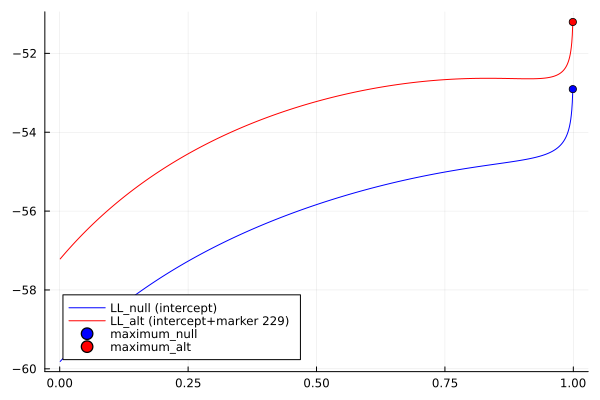

In [1250]:
plot(hsqs, full_results[1], color = "blue", label = "LL_null (intercept)", legend =:bottomleft)
plot!(hsqs, full_results[2], color = "red", label = "LL_alt (intercept+marker 229)")
scatter!([hsqs[max_noBayes_null[2]]], [max_noBayes_null[1]], color = "blue", label = "maximum_null")
scatter!([hsqs[max_noBayes_alt[2]]], [max_noBayes_alt[1]], color = "red", label = "maximum_alt")

In [1251]:
hsqs_from_alt_b[229]

0.8129896939872916

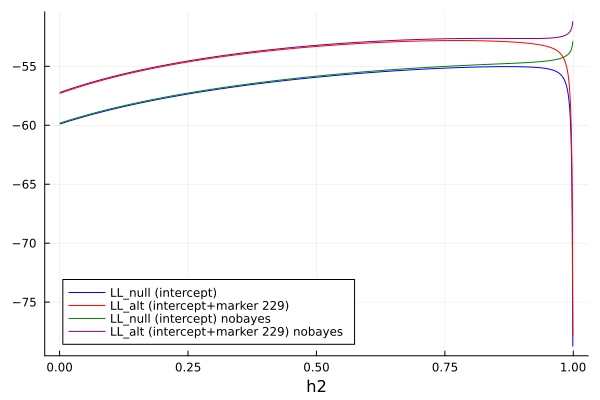

In [1253]:
plot(hsqs, full_results[3], color = "blue", label = "LL_null (intercept)", xlabel = "h2", legend =:bottomleft)
plot!(hsqs, full_results[4], color = "red", label = "LL_alt (intercept+marker 229)")
plot!(hsqs, full_results[1], color = "green", label = "LL_null (intercept) nobayes")
plot!(hsqs, full_results[2], color = "purple", label = "LL_alt (intercept+marker 229) nobayes")
# scatter!([hsq_from_null_b], [full_results[3][Int(floor(hsq_from_null_b*100))]], color = "blue", label = "maximum_null")
# scatter!([hsqs_from_alt_b[229]], [full_results[4][Int(floor(hsqs_from_alt_b[229]*100))]], color = "red", label = "maximum_alt")

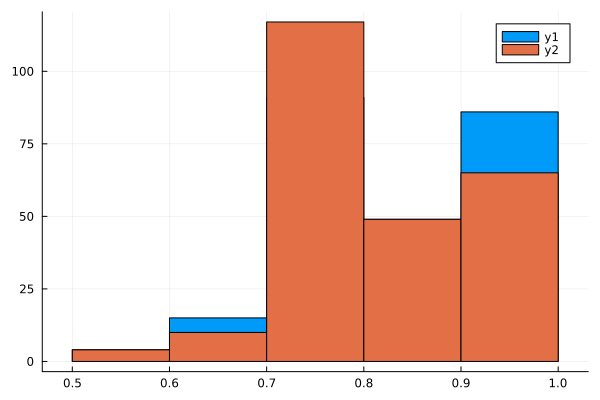

In [1166]:
hsqs_assoc_neg = hsqs_from_alt[findall(lods_from_alt .< 0)];
hsqs_assoc_neg_b = hsqs_from_alt_b[findall(lods_from_alt .< 0)];
histogram(hsqs_assoc_neg)
histogram!(hsqs_assoc_neg_b)

## Assuming what we do is correct...

In [1357]:
?fitlmm

search: fitlmm FisherNoncentralHypergeometric



fitlmm: fit linear mixed model using grid of values

y: 2-d array of (rotated) phenotypes X: 2-d array of (rotated) covariates lambda: 1-d array of eigenvalues ngrid: number of grid values to consider

---

fitlmm: fit linear mixed model

y: 2-d array of (rotated) phenotypes X: 2-d array of (rotated) covariates lambda: 1-d array of eigenvalues reml: boolean indicating ML or REML estimation


In [1361]:
function scan_alt_corrected(y::Array{Float64, 2}, g::Array{Float64, 2}, K::Array{Float64, 2}; 
                  prior::Array{Float64, 1} = [0.0, 0.0],
                  reml::Bool = false, method::String = "qr")

    # number of markers
    (n, p) = size(g);
    
    # rotate data
    (y0, X0, lambda0) = transform_rotation(y, g, K);

    pve_list = Array{Float64, 1}(undef, p);

    X00 = reshape(X0[:, 1], :, 1);
    # fit null lmm
    # out00 = fitlmm(y0, X00, lambda0; reml = reml, method = method);
    # out00 = fitlmm(y0, X00, lambda0; reml = reml);

    lod = zeros(p);
    X = zeros(n, 2);
    X[:, 1] = X0[:, 1];
    
    out00_bayes = fitlmm(y0, X00, lambda0, prior; reml = reml, method = method);
    
    for i = 1:p
        X[:, 2] = X0[:, i+1];
        
        # out11 = fitlmm(y0, X, lambda0; reml = reml, method = method);
        # out11 = fitlmm(y0, X, lambda0; reml = reml);
        
        # curr_lod = (out11.ell - out00.ell)/log(10);
        # curr_h2 = out11.h2;
        
        # Check results validity
        if true
            # out00_bayes = fitlmm(y0, X00, lambda0, prior; reml = reml, method = method);
            out11_bayes = fitlmm(y0, X, lambda0, prior; reml = reml, method = method);
            
            curr_lod = (out11_bayes.ell - out00_bayes.ell)/log(10);
            curr_h2 = out11_bayes.h2;
        end
        
        
        pve_list[i] = curr_h2;
        lod[i] = curr_lod;
        
    end

    return (out00_bayes.sigma2, out00_bayes.h2, pve_list, lod)

end

scan_alt_corrected (generic function with 2 methods)

In [1362]:
prior

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [1423]:
prior = [var(pheno[:, 108]), 1];

In [1413]:
var(pheno[:, 108])

1.6944289276209026

In [1424]:
results_corrected = scan_alt_corrected(pheno_108, geno, kinship_Gc; prior = prior, reml = false, method = "qr");

In [1425]:
hcat(results_scan_alt[4], results_corrected[4], lods_from_gemma[:, 108])

7321×3 Matrix{Float64}:
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.0219153  0.00910017  0.0219155
 0.021912   0.00909824  0.0219122
 0.0567256  0.0461259   0.0567251
 ⋮                      
 0.248678   0.249071    0.248678
 0.248678   0.249071    0.248678
 0.248678   0.249071    0.248678
 0.0686881  0.144392    0.0686887
 0.124881   0.134296    0.124882
 0.124881   0.134296    0.124882
 0.249213   0.252423    0.249213
 0.273645   0.282972    0.273645
 0.271594   0.280134    0.271594
 0.285893   0.303347    0.285893
 0.229505   0.213487    0.229504
 0.229505   0.213487    0.229504

In [1426]:
isNegative = findall(results_scan_alt[4] .< 0)

245-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

In [1427]:
findall(results_corrected[4] .< 0)

Int64[]

In [1428]:
summary_corrected = hcat(results_scan_alt[4][isNegative], results_corrected[4][isNegative], lods_from_gemma[:, 108][isNegative]);
summary_corrected = vcat(["before" "corrected_by_bayes" "gemma"], summary_corrected)

246×3 Matrix{Any}:
   "before"   "corrected_by_bayes"   "gemma"
 -2.2873     1.0417                 0.736546
 -2.2873     1.0417                 0.736546
 -2.2873     1.0417                 0.736546
 -2.36798    1.02061                0.582913
 -1.41325    1.99966                1.3266
 -1.50067    1.87392                1.30913
 -1.67281    1.70801                1.16035
 -1.67281    1.70801                1.16035
 -1.90021    1.491                  0.930859
 -1.90021    1.491                  0.930859
 -1.90013    1.49109                0.930918
 -1.55903    1.83623                1.16779
  ⋮                                 
 -2.9462     0.537266               0.0473551
 -2.94618    0.537287               0.0473611
 -2.94618    0.537287               0.0473611
 -2.16293    1.24862                0.77996
 -2.51206    0.879469               0.525381
 -2.57682    0.780697               0.475996
 -2.57682    0.780697               0.475996
 -2.46246    0.932586               0.582341
 -2

In [1429]:
maximum(abs.(results_corrected[4][isNegative] .- lods_from_gemma[:, 108][isNegative]))

0.7975245530758133

In [1433]:
pheno_y = reshape(pheno[:, 109], :, 1);

In [1441]:
prior = [var(pheno[:, 109]), 1/10];

In [1442]:
@btime scan_alt_corrected(pheno_y, geno, kinship_Gc; prior = prior, reml = false, method = "qr");

  1.778 s (2631705 allocations: 1.18 GiB)


In [1443]:
@btime scan_alt(pheno_y, geno, kinship_Gc; reml = false);

  1.805 s (2742424 allocations: 1.26 GiB)


In [1444]:
@btime scan_alt_corrected(pheno_y, geno, kinship_Gc; prior = prior, reml = false, method = "cholesky");

  1.205 s (2270916 allocations: 941.10 MiB)
